In [1]:
#ini-iPython

# Executando no diretório principal

In [2]:
import os
os.chdir("/home/vinicius/Dropbox/Projeto Mestrado/Codigos/RoboFEI-HT_Debug/AI/Visual_Memory") #Executando na pasta Vision
import sys
sys.path.append("./include")
sys.path.append("./src")
sys.path.append("./iPython")
#end-iPython

---- Imports ----

In [3]:
# Libraries to be used.
import sys
#des-iPython sys.path.append("../include")
#des-iPython sys.path.append("../src")

In [4]:
# The standard libraries used in the visual memory system.


In [5]:
# Used class developed by RoboFEI-HT.
from Basic import * # Class with implementations and basic variables
sym.init_printing() #debug-iPython

# Class to Speeds
Class responsible for managing the robot's possible speeds (me).
doxygen-iPython

In [6]:
#des-iPython class Speeds( ):
#ini-tab -> Iniciando código classe

---- Variables ----

# __movementslist
Velocity list of robot movements.
doxygen-iPython

In [7]:
__movementslist = [] #self-iPython __movementslist

# __B
Speed matrix $B_t$.
doxygen-iPython

In [8]:
__B = None #self-iPython __B

# __R
Speed error matrix $R_t$.
doxygen-iPython

In [9]:
__R = None #self-iPython __R

In [10]:
#ini-iPython

# ------- Lista de funções herdadas -------



# ------- Lista variaveis herdadas -------



# ------- Lista de funções -------

#self-iPython update
#self-iPython __getitem__

#end-iPython - Fim listas

# Constructor Class
Initializes basic network parameters and creates standard speeds.
doxygen-iPython

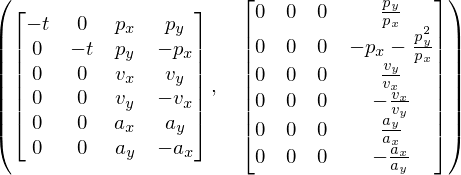

In [659]:
#des-iPython def __init__(self):
#ini-tab -> Criando construtor
__movementslist.append({
    "U": sym.Matrix([
        [0, 0, 0,],
        [0, 0, 0,],
        [0, 0, 0,],
        [0, 0, 0,],
        [0, 0, 0,],
        [0, 0, 0,],
    ]),

    "R": sym.Matrix(sym.Identity(6)*0)
})



__t = sym.symbols("t") # Declaring variable time


p_x, p_y = sym.symbols("p_x, p_y")
v_x, v_y = sym.symbols("v_x, v_y")
a_x, a_y = sym.symbols("a_x, a_y")
vr_x, vr_y, omegar = sym.symbols("vr_x, vr_y, \\omega\ r")
R_p, R_v, R_a = sym.symbols("R_p R_v R_a")

__B = sym.Matrix([
    [-__t*vr_x, 0, 0],
    [0, -__t*vr_y, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
])

__R = sym.Matrix(sym.Identity(6)*1000)


np_x = p_x -__t*vr_x*sym.sin(sym.pi/2 - __t*omegar) - __t*vr_y*sym.cos(sym.pi/2 + __t*omegar)
np_y = p_y -__t*vr_x*sym.cos(sym.pi/2 - __t*omegar) - __t*vr_y*sym.sin(sym.pi/2 + __t*omegar)
# np_x, np_y = sym.symbols("np_x np_y")

# Para movimentos
Z = sym.Matrix([
    [p_x*sym.cos(omegar*__t)+p_y*sym.sin(omegar*__t) - __t*vr_x],
    [-p_x*sym.sin(omegar*__t)+p_y*sym.cos(omegar*__t) - __t*vr_y],
    [v_x*sym.cos(__t*omegar)+v_y*sym.sin(__t*omegar)],
    [-v_x*sym.sin(__t*omegar)+v_y*sym.cos(__t*omegar)],
    [a_x*sym.cos(__t*omegar)+a_y*sym.sin(__t*omegar)],
    [-a_x*sym.sin(__t*omegar)+a_y*sym.cos(__t*omegar)],
])

u = sym.Matrix([
    [vr_x],
    [vr_y],
    [sym.cos(omegar*__t)],
    [sym.sin(omegar*__t)],
])

B = sym.Matrix([
    [-__t, 0, p_x, p_y],
    [0, -__t, p_y, -p_x],
    [0, 0, v_x, v_y],
    [0, 0, v_y, -v_x],
    [0, 0, a_x, a_y],
    [0, 0, a_y, -a_x],
])

B, sym.Matrix([
    [p_x, 0, 0, 0, 0, 0],
    [p_y, 1, 0, 0, 0, 0],
    [0, 0, v_x, 0, 0, 0],
    [0, 0, 0, v_y, 0, 0],
    [0, 0, 0, 0, a_x, 0],
    [0, 0, 0, 0, 0, a_y],
]).inv() * sym.Matrix([
    [0, 0, 0, p_y],
    [0, 0, 0, -p_x],
    [0, 0, 0, v_y],
    [0, 0, 0, -v_x],
    [0, 0, 0, a_y],
    [0, 0, 0, -a_x],
])

In [643]:
#end-tab -> Finalizando construtor
#ini-iPython

SyntaxError: can't assign to operator (<ipython-input-643-3a0eaf7eab2a>, line 1)

## Teste construtor

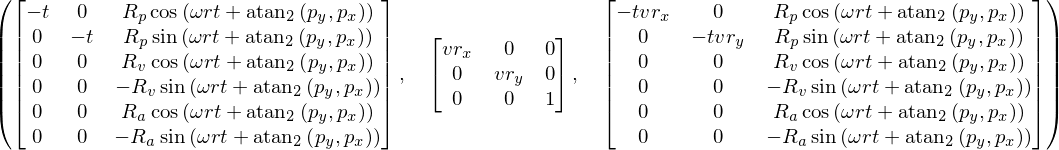

In [27]:
f_vr_x, f_vr_y, f_omegar = sym.symbols("f_{vr_x}, f_{vr_y}, f_{\\omega\ r}")
# u_t = sym.Matrix([
#     [f_vr_x],
#     [f_vr_y],
#     [f_omegar]
# ])
# u_t = sym.Matrix([
#     [1],
#     [1],
#     [1]
# ])

__B, __R
# (__B*u_t).subs([
#     [__t, 1],
#     [omegar, sym.pi/2],
#     [p_x, 3],
#     [p_y, 0],
    
# ])

U2 = sym.Matrix([
    [vr_x , 0, 0],
    [0, vr_y, 0],
    [0, 0, 1],
])

U1 = sym.sympify(__B*sym.Inverse(U2))

U1, U2, U1*U2
#end-iPython

# update
Adds average robot speeds or upgrades to speeds.
@param vector Observed speed.
doxygen-iPython

In [14]:
#eself-iPython update
#edes-iPython def update(self, vector):
def update(vector):
    if vector[0] + 1 > len(__movementslist):
        while vector[0] + 1 > len(__movementslist):
            __movementslist.append(
                {
                    "U": copy(__B),
                    "R": copy(__R),
                }
            )
    
    
    __movementslist[vector[0]]["U"] = vector[1]
    __movementslist[vector[0]]["R"] = vector[2] #self-iPython update

In [15]:
#ini-iPython

## Teste update

3


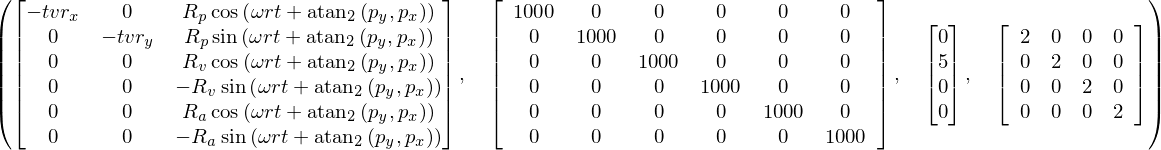

In [16]:
speed = sym.Matrix([0, 5, 0, 0])
covariance = sym.Matrix(sym.Identity(4)*2)
vector = [
    2,
    speed,
    covariance,
]

__movementslist = []
update(vector)

print len(__movementslist)
__movementslist[1]["U"], __movementslist[1]["R"], __movementslist[vector[0]]["U"], __movementslist[vector[0]]["R"]
#end-iPython

# __getitem__
Returns the dictionary of motion vectors.
@param x Vector position to be accessed.
@return Returns the dictionary that will be used.
doxygen-iPython

In [17]:
#eself-iPython __getitem__
#edes-iPython def __getitem__(self, x):
def __getitem__(x):
    return __movementslist[x] #self-iPython __getitem__

In [18]:
#ini-iPython

## Teste __getitem__

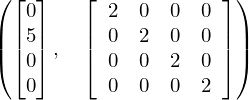

In [19]:
a = 2
__getitem__(a)["U"], __getitem__(a)["R"]
#end-iPython

In [20]:
#end-tab -> Finalizando classe

In [21]:
#ini-iPython

# nova_variavel
.
doxygen-iPython

In [22]:
nova_variavel = None #self-iPython nova_variavel

# nova_funcao
doxygen-iPython

In [23]:
# eself-iPython nova_funcao
# edes-iPython def nova_funcao(self, variaveis_funcao):
def nova_funcao(variaveis_funcao):
    pass # self-iPython nova_funcao

In [24]:
#ini-iPython

## Teste nova_funcao

In [25]:

#end-iPython

In [26]:
#end-iPython